# World Quant Predictive Researcher Prog Test

## 1. Problem and data description
In this challenge a series of corrupted words is given and the task is to retrieve their original state given a series of training tokens. There are explicit assumptions in the problem description and implicit ones too and it is important to consider them. 

The series was generated by breaking down sentences into separate tokens while removing all punctuations. This means that it is uncertain where a sentence starts or ends and where parts are separated by hyphen - common case is mentioning an example. With that being said the context of a token (the tokens before and after the current position) is somewhat unreliable and I am going to ignore it throughout this solution. Luckily the task relaxes the assumption that the casing of a token matters. Another assumption I will make is that hashmarks are reserved only to for corrupted tokens to signal missing characters.

The task comes with a training data and a list of corrupted tokens, but there is no information given on their correct forms. Which means it is not possible to measure the efficiency of the model, unless I split the training data and separate some amount for testing - which I will transform by adding noise to it. I will use that to measure how many times the prediction equals to the original form. Usually it would be a good idea to do a cross validation of the model, but for the sake of simplicity I will not do that here.

Given the above assumption of positional independence it is safe to store the series in a more compressed format than a list. First I will use a Counter object which storess key and their corresponding frequencies as values in an ordered form. It will make it easier to query the most and least common tokens in the data. Below I have created a function which loads a series of tokens, split it if needed and loads it into a new Counter object. I have also printed a couple of general observations about the data.

In [67]:
from collections import Counter

from sklearn.model_selection import train_test_split

def read_data(path, ignore_hash=True, split=False):

    tokens = []
    with open(path, 'r') as f:
        for line in f:
            t = line.strip().lower()
            if ~ignore_hash & ('#' in t):
                print(f'Warning: # in token {t}')
            tokens.append(t)

    if split:
        train_data, test_data = train_test_split(tokens, train_size=0.7, test_size=0.3, shuffle=True)
        train_data, test_data = Counter(train_data), Counter(test_data)
        return train_data, test_data
    
    else:
        tokens = Counter(tokens)
        return tokens

training_data, test_data = read_data('data/training_tokens.txt', ignore_hash=False, split=True)
print(f'The top 10 most common words in the vocabulary: {training_data.most_common(10)}')
print(f'The number of unique words in the training data: {len(training_data)}')
print(f'Total number of words in the training data: {sum(v for _, v in training_data.items())}')
print(f'The number of unique words in the test data: {len(test_data)}')
print(f'Total number of words in the test data: {sum(v for _, v in test_data.items())}')

The top 10 most common words in the vocabulary: [('the', 15989), ('and', 11439), ('of', 7835), ('a', 7479), ('to', 7132), ('i', 5278), ('it', 4947), ('in', 4845), ('that', 4203), ('was', 3878)]
The number of unique words in the training data: 17283
Total number of words in the training data: 284356
The number of unique words in the test data: 11904
Total number of words in the test data: 121867


First of all not surprisingly the most common words in the training data are function words, like the or and. This is very common in natural languages, because they are used to form and construct logic in sentences. The most common word is occurring 29% more than the second one which appears 30% more than the third. It looks almost as if there is an exponential decrease in frequency. This behaviour is a very common trait of the distribution of words of various natural languages. This observation will come handy later.

## 2. Modeling
The problem here is to find a string that matches the original form based on a noisy input. A common solution to this problem is to do a comparision between the noisy input and tokens in a corpus and then return the token with the smallest distance from the input. Usually the levenshtein distance is used as the notion of distance between two strings, which measures the number of deletions, insertions or replacements needed to transform a to b. This usually requires a lot of comparisions if the corpus is large or the search is not guided in some way. Luckily there are data structures that can facilitate this, for example Directed Acyclic Word Graphs. DAWGs combine vocabularys or corposes into a compressed format by breaking down words into characters and form a graph where words with similar patterns share the same path. So for example the words cat and mat would share the node a.

Now given that the corrupted tokens are very noisy it can happen that the search would retrieve multiple suggestions. As I have mentioned earlier some words appear much more frequently that others so it would be reasonable to expect that exploiting this fact in the modeling process would be a good start. So the basic model will count the number of corruptions in the noisy input which will give a boundary for the similarity search in the dawg. Then matches are filtered based on length and then the token with the highest frequency in the training corpus is returned. If there are no matches then the model will return None.

In [68]:
from operator import itemgetter

from lexpy.dawg import DAWG # Directed Acyclic Word Graph

def dawg_predictor(lexicon, token):

    n_missing = token.count('#')
    token = token.lower()
    P = lexicon.search_within_distance(token, dist=n_missing)
    P = [(p_i, training_data[p_i]) for p_i in P if len(token) == len(p_i)]

    if P:
        prediction = max(P, key=itemgetter(1))[0]
    else:
        prediction = None

    return prediction


lex = DAWG()
lex.add_all([t for t in sorted(training_data.keys())])
lex.reduce()

## 3. Testing on corrupted tokens

As I have mentioned above the real form of the corrupted tokens is not available, but it would be beneficial if there was a ways to understand the performance of the proposed solution. Earlier I have splitted the training data to separate some of it for testing purposes. However it is not clear how I should add noise to the test data to somewhat mimic the noise generation process. Therefore I will load the corrupted tokens with the function defined earlier to eyeball it to reproduce it later.

In [69]:
corrupted_data = read_data('data/corrupted_tokens.txt', ignore_hash=True)
print(f'The top 10 most common words in the vocabulary: {corrupted_data.most_common(10)}')
print(f'The 10 least common words in the vocabulary: {corrupted_data.most_common()[-10:]}')
print(f'The number of unique words in the vocabulary: {len(corrupted_data)}')
print(f'Total number of words: {sum(v for _, v in corrupted_data.items())}')

The top 10 most common words in the vocabulary: [('t#e', 1918), ('i#', 1660), ('a#d', 1310), ('o#', 1306), ('a', 906), ('t#', 609), ('t#a#', 456), ('a#', 440), ('t#e#', 399), ('w#s', 379)]
The 10 least common words in the vocabulary: [('w#r#d#', 1), ('b#g#i#e#', 1), ('w#s#e', 1), ('r#v#s#e#', 1), ('i#c#n#e', 1), ('e#e#t#a#', 1), ('p#r#a#e#c#', 1), ('m#s#e#y', 1), ('a#c#a#g#l', 1), ('k#e#s#k#', 1)]
The number of unique words in the vocabulary: 4324
Total number of words: 29293


In the output above the first thing that the code printed was the top 10 most common corrupted tokens and then just below the 10 least common ones. First it seems like that hashmarks occur on every second position of a token, so I will make a method that will add noise to my test tokens in a similar fashion. Second it seems like that the distribution of the frequencies of the words have a tendency of decreasing sharply which is a similar observation to the one made earlier. It could be misleading though, because some characters are hidden and thus the same corrupted token could represent multiple real tokens.

### 3.1 Accuracy on the test data

Below I will define the noise generation function and I will use output of that to pass it to the model. The prediction of the model is then compared to the original token. I will measure the effectiveness of the proposed solution by comparing the sum of exact matches to the size of the test set - this is usually would be called accuracy the metric. I will look at two ways of calculating the accuracy. First I will compare the sum of the frequencies of the correctly predicted tokens to the sum of all the frequencies in the set. Then I will repeat this using only the count of correctly predicted tokens and comparing to the count of all the unique tokens in the test set. The first approach assumes that tokens appearing more frequently in the set have higher weight or importance. The second one assumes uniform weight for all tokens. The choice between them depends on the business requirement. More on that below.

In [70]:
def add_noise(token):

    return ''.join(['#' if (j%2)==1 else c for j, c in enumerate(token)])

test_word = "levenshtein"
print(f'Original word: {test_word}, Result of adding noise: {add_noise(test_word)}')
pred_scores = [f for t, f in test_data.items() if dawg_predictor(lex, add_noise(t)) == t]
acc_w = sum(pred_scores) / sum(f for _, f in test_data.items())
acc_u = len(pred_scores) / len(test_data)
print(f'Weighted Accuracy: {acc_w*100:.2f}%')
print(f'Unweighted Accuracy: {acc_u*100:.2f}%')

Original word: levenshtein, Result of adding noise: l#v#n#h#e#n
Weighted Accuracy: 82.54%
Unweighted Accuracy: 59.06%


First of all the result of the noise generation function given a test word seems to be doing its job. Exactly every second character has been changed to a hashmark.

Second, it seems there is a notable difference between the weighted and unweighted accuracies on the test set. This is expected if we consider the earlier observation about the distribution of word frequencies. Because some words appear much more frequently than others then the correct prediction of some commonly appearing words are pushing the metric to appear better. It is important to mention that the model itself is biased to choose the words with the higher frequency. Now it is important to consider which reflects the final purpose better. The task does not specify, only asks "to recover the corrupted tokens as best you can". Now let's say I have a business which has a product that can process text and has a spellchecking capability. Would it be more important for my tool to recover the frequently appearing words or the rare ones?

Now using the developed tool I can finally take a guess at the original form of the corrupted tokens. I will print the predictions of the top 15 most and least common tokens respectively.

### 3.2 Recovery rate on corrupted tokens

In [77]:
print('Predictions for the top 15 most common corrupted tokens')
for tok, _ in corrupted_data.most_common(15):
    pred = dawg_predictor(lex, tok)
    print(f'token: {tok}, prediction: {pred}')

Predictions for the top 15 most common corrupted tokens
token: t#e, prediction: the
token: i#, prediction: it
token: a#d, prediction: and
token: o#, prediction: of
token: a, prediction: a
token: t#, prediction: to
token: t#a#, prediction: that
token: a#, prediction: as
token: t#e#, prediction: they
token: w#s, prediction: was
token: h#, prediction: he
token: h#s, prediction: his
token: i, prediction: i
token: b#, prediction: by
token: f#r, prediction: for


In [78]:
print('Predictions for the 15 least common corrupted tokens')
for tok, _ in corrupted_data.most_common()[-15:]:
    pred = dawg_predictor(lex, tok)
    print(f'token: {tok}, prediction: {pred}')

Predictions for the 15 least common corrupted tokens
token: a#n#l#e#, prediction: None
token: r#i#s, prediction: rails
token: r#b#, prediction: ribs
token: e#s#a#e#, prediction: None
token: m#t#b#l#, prediction: None
token: w#r#d#, prediction: worlds
token: b#g#i#e#, prediction: beguiled
token: w#s#e, prediction: waste
token: r#v#s#e#, prediction: None
token: i#c#n#e, prediction: None
token: e#e#t#a#, prediction: None
token: p#r#a#e#c#, prediction: permanency
token: m#s#e#y, prediction: mystery
token: a#c#a#g#l, prediction: archangel
token: k#e#s#k#, prediction: None


Looking at the result of the predictions for the least common tokens in the vocabulary it seems there are some tokens that the model failed to recover. It would be interesting to see exactly how many times the model is returning None as a result. This way I can at least have a sense of how my model performs on the corrupted data. For this reason I have created a graph of the number of times the prediction was succesful (there was an answer from the model) compared to the case when it was not. Again I am comparing the results for the unique tokens versus the case of all tokens in the corpus.

In [79]:

Y = {t: dawg_predictor(lex, t) for t in corrupted_data}
P = [f for t, f in corrupted_data.items() if Y[t] is not None]
P_u = len(P) # number of unique recoveries
P = sum(P) # total number of recoveries
N = sum(v for _, v in corrupted_data.items()) # total number of tokens in the corrupted_tokens corpus
N_u = len(corrupted_data) # number of unique corrupted tokens

In [80]:
print(f'Total number of tokens: {N}')
print(f'Total number of succesful recoveries: {P}')
print(f'Unique token count: {N_u}')
print(f'Unique tokens recovered: {P_u}')

Total number of tokens: 29293
Total number of succesful recoveries: 28181
Unique token count: 4324
Unique tokens recovered: 3511


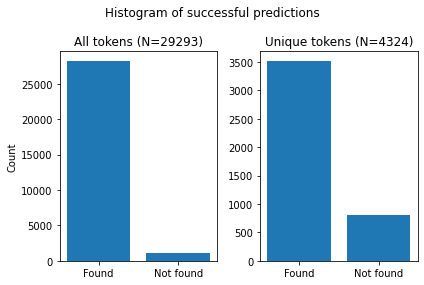

In [81]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Histogram of successful predictions')

ax1.bar(x=['Found', 'Not found'], height=[P, N-P])
ax1.set_ylabel('Count')
ax1.set_title(f'All tokens (N={N})')
ax2.bar(x=['Found', 'Not found'], height=[P_u, N_u-P_u])
ax2.set_title(f'Unique tokens (N={N_u})')

plt.tight_layout()

Judging by the above statistics and the plotted graph there is a difference between the two approaches, but not as significant as in the case with accuracy. It is important to note however that in the in the accuracy measurement the criteria was stricter. Nevertheless it signals an important issue with most natural language processing problems: the training distribution and the test distribution (and the data found in real settings) differ and the prior do not encompass all information about the latter. It is sometimes because the test set containts out of vocabulary words or it could be due to the limited size of the training sample. Most often it is the prior and that is because language is simply non-stationary. Which means that language often changing, new words can appear or old ones can appear in new forms due to some transformation (especially in agglutinative languages).

The only task left is to write the recovered tokens into an output.

In [82]:
corrupted_file = open('data/corrupted_tokens.txt', 'r')
with open('data/recovered_tokens.txt', 'w') as output:
    for line in corrupted_file:
        t = line.strip().lower()
        p = Y.get(t, t)
        output.write(f'{p}\n')
corrupted_file.close()

## 4. Summary

In this challenge the task was to recover the original form of a set of corrupted tokens given a set of training tokens. I have given a description of the assumptions in the task and created a model that reflected those assumptions, but was also able to scale better than some other approaches used regularly. The modeling process reflected the observation that some tokens appeared much more frequently in the training data than other tokens. I have also made an attempt at measuring the efficiency of the submission using a holdout test set - splitted from the training data - and the recoveries on the corrupted data. I have showed different approaches in the efficiency measurement and highlighted how those can reflect different business goals. Finally I have written the recovered tokens into a text file.